In [26]:
"""
Deadline predictor using multiple projects:
Aurora, Meso, Spring XD, UserGrid.

Predicts recommended deadline (in days) for new tasks/tickets
based on story points, priority, velocity, dependencies, etc.
"""

import os, math, warnings
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
import joblib
from flask import Flask, request, jsonify
warnings.filterwarnings("ignore")


In [27]:
# -----------------------------
# 1) CSV PATHS (HARDCODED)
# -----------------------------
MODEL_PATH = "models/deadline_model_all_projects.joblib"

PROJECTS = {
    "Aurora": {
        "issues":  r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Aurora Project\Aurora Issues 554.csv",
        "summary": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Aurora Project\Aurora Issues summery 568.csv",
        "sprints": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Aurora Project\Aurora Sprints 41.csv",
    },
    "Meso": {
        "issues":  r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Meso Project\Mesos Stories 176.csv",
        "summary": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Meso Project\MESO Issue Summary 370.csv",
        "sprints": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Meso Project\MESO Sprint 96.csv",
    },
    "SpringXD": {
        "issues":  r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Spring XD Project by Randula\Spring XD Issues 1992.csv",
        "summary": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Spring XD Project by Randula\Spring XD Issues Summary 2861.csv",
        "sprints": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Spring XD Project by Randula\Spring XD Sprints 67.csv",
    },
    "UserGrid": {
        "issues":  r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for UserGrid\Usergrid Issues 824.csv",
        "summary": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for UserGrid\Usergrid Issues Summary 929.csv",
        "sprints": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for UserGrid\Usergrid Sprints 36.csv",
    },
}


In [28]:
# -----------------------------
# 2) HELPERS
# -----------------------------
def _lower_cols(df):
    df = df.copy()
    df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]
    return df

def _parse_date(x):
    if pd.isna(x): return np.nan
    try:
        return pd.to_datetime(x, errors="coerce")
    except: return np.nan

def safe_div(a,b,default=0.0):
    try:
        return float(a)/float(b) if b and not pd.isna(b) else default
    except: return default

def coalesce(*vals):
    for v in vals:
        if v is not None and not (isinstance(v,float) and np.isnan(v)): return v
    return np.nan

def priority_multiplier(pid):
    mapping = {1:0.7,2:0.85,3:1.0,4:1.2,5:1.4}
    try: return mapping.get(int(pid),1.0)
    except: return 1.0

def dependency_inflation(row):
    blk=coalesce(row.get("blockedby"),0); bls=coalesce(row.get("blocks"),0)
    dob=coalesce(row.get("dependedonby"),0); dep=coalesce(row.get("dependedon"),0)
    links=coalesce(row.get("issuelinks"),0); subs=coalesce(row.get("subtasks"),0)
    infl=1+0.2*blk+0.1*bls+0.08*dob+0.06*dep+0.03*links+0.05*subs
    return min(infl,2.0)

In [29]:
# -----------------------------
# 3) LOAD & MERGE ALL PROJECTS
# -----------------------------
combined = []

for pname, p in PROJECTS.items():
    try:
        print(f"Loading {pname} ...")
        iss = _lower_cols(pd.read_csv(p["issues"], on_bad_lines="skip", engine="python"))
        summ = _lower_cols(pd.read_csv(p["summary"], on_bad_lines="skip", engine="python"))
        spr  = _lower_cols(pd.read_csv(p["sprints"], on_bad_lines="skip", engine="python"))
    except Exception as e:
        raise RuntimeError(f"❌ Failed loading {pname}: {e}")

    # --- normalize naming ---
    rename_map = {"priority": "priorityid", "priority_id": "priorityid", "storypoints": "storypoint"}
    iss.rename(columns={k: v for k, v in rename_map.items() if k in iss.columns}, inplace=True)
    summ.rename(columns={k: v for k, v in rename_map.items() if k in summ.columns}, inplace=True)

    # --- sprint derived fields ---
    for c in ["sprintstartdate", "sprintenddate", "sprintcompletedate"]:
        if c in spr.columns:
            spr[c] = spr[c].apply(_parse_date)
    if "sprintlength" not in spr.columns:
        spr["sprintlength"] = (spr["sprintenddate"] - spr["sprintstartdate"]).dt.days.clip(lower=1)
    spr["velocity_sp_per_day"] = spr.apply(
        lambda r: safe_div(r.get("completedissuesestimatesum", 0), r.get("sprintlength", 0)),
        axis=1
    )

    # --- ensure sprint id consistency ---
    if "sprint" in iss.columns and "sprintid" not in iss.columns:
        iss.rename(columns={"sprint": "sprintid"}, inplace=True)

    # --- merge summary + sprint ---
    if "sprintid" not in summ.columns or "sprintid" not in spr.columns:
        raise KeyError(f"Missing 'sprintid' in {pname} summary or sprint data")

    join = summ.merge(spr, on="sprintid", how="left", suffixes=("", "_spr"))

    # --- merge with issues ---
    if "issuekey" not in join.columns or "key" not in iss.columns:
        raise KeyError(f"Missing issue key columns for {pname}")

    join = join.merge(
        iss[
            [
                c for c in [
                    "key", "issuetype", "status", "storypoint", "watchcount",
                    "votes", "commentcount", "blockedby", "blocks",
                    "dependedonby", "dependedon", "issuelinks", "subtasks",
                    "priorityid"
                ] if c in iss.columns
            ]
        ],
        left_on="issuekey",
        right_on="key",
        how="left",
        suffixes=("", "_issue")
    )

    # --- required columns must exist ---
    required_cols = ["priorityid", "status", "storypoint"]
    for col in required_cols:
        if col not in join.columns:
            raise KeyError(f"❌ {pname} missing required column '{col}' after merge.")

    # --- consolidate if duplicated between summary/issue ---
    if "priorityid_issue" in join.columns:
        join["priorityid"] = join["priorityid"].combine_first(join["priorityid_issue"])
    if "status_issue" in join.columns:
        join["status"] = join["status"].combine_first(join["status_issue"])
    if {"currentstorypoint", "initialstorypoint"} <= set(join.columns):
        join["storypoint"] = join["currentstorypoint"].combine_first(join["initialstorypoint"]).combine_first(join["storypoint"])

    join["project"] = pname
    combined.append(join)
    print(f"✅ Loaded {pname}: {join.shape}")

# --- combine all ---
if not combined:
    raise RuntimeError("❌ No project data loaded — check file paths above.")

df = pd.concat(combined, ignore_index=True)
print("✅ Loaded combined shape:", df.shape)


Loading Aurora ...
✅ Loaded Aurora: (910, 47)
Loading Meso ...
✅ Loaded Meso: (819, 47)
Loading SpringXD ...
✅ Loaded SpringXD: (3066, 47)
Loading UserGrid ...
✅ Loaded UserGrid: (2259, 47)
✅ Loaded combined shape: (7054, 49)


In [30]:
# -----------------------------
# 4) CREATE TARGET
# -----------------------------
for c in ["created","createddate","resolutiondate","resolved","done"]:
    if c in df.columns: df[c]=df[c].apply(_parse_date)
date_created_col=next((c for c in df.columns if "created" in c),None)
date_resolved_col=next((c for c in df.columns if "resolution" in c or "resolved" in c or "done"==c),None)

def compute_target_days(row):
    created=row.get(date_created_col); resolved=row.get(date_resolved_col)
    sprint_end=row.get("sprintenddate"); vel=row.get("velocity_sp_per_day",0)
    sp=coalesce(row.get("currentstorypoint"),row.get("initialstorypoint"),row.get("storypoint"),1)
    if pd.notna(created) and pd.notna(resolved):
        d=(resolved-created).days
        if d>0: return d
    if pd.notna(created) and pd.notna(sprint_end):
        d=(sprint_end-created).days
        if d>0: return d
    if vel>0 and sp: return math.ceil(sp/vel)
    return np.nan

df["target_days"]=df.apply(compute_target_days,axis=1)

In [31]:
safe_num_feats = [
    "currentstorypoint",
    "priorityid",
    "watchcount",
    "votes",
    "commentcount",
    "blockedby",
    "blocks",
    "dependedonby",
    "dependedon",
    "issuelinks",
    "subtasks",
    "noofdevelopers"
]
safe_cat_feats = ["issuetype", "status", "project"]

X_safe = df[safe_num_feats + safe_cat_feats]
y_safe = df["target_days"].astype(float)
mask = y_safe.notna() & (y_safe > 0)
X_safe = X_safe[mask]
y_safe = y_safe[mask]

# same pipeline but with fewer features
pipe_safe = Pipeline([
    ("prep", ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler(with_mean=False))
        ]), safe_num_feats),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), safe_cat_feats)
    ])),
    ("reg", GradientBoostingRegressor(random_state=42))
])

Xtr, Xte, ytr, yte = train_test_split(X_safe, y_safe, test_size=0.2, random_state=42)
pipe_safe.fit(Xtr, ytr)
y_pred = pipe_safe.predict(Xte)

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
mae = mean_absolute_error(yte, y_pred)
mape = mean_absolute_percentage_error(yte, y_pred)
r2 = r2_score(yte, y_pred)
print(f"MAE: {mae:.2f}, MAPE: {mape:.2%}, R²: {r2:.3f}")


MAE: 1.02, MAPE: 36.71%, R²: 0.814


In [32]:
train_projects = ["Aurora", "Meso", "SpringXD"]
test_project = "UserGrid"

mask_train = df["project"].isin(train_projects)
mask_test = df["project"] == test_project

Xtr, Xte = X_safe[mask_train], X_safe[mask_test]
ytr, yte = y_safe[mask_train], y_safe[mask_test]

pipe_safe.fit(Xtr, ytr)
y_pred = pipe_safe.predict(Xte)

mae = mean_absolute_error(yte, y_pred)
r2 = r2_score(yte, y_pred)
print(f"Cross-project test on {test_project}: MAE={mae:.2f}, R²={r2:.3f}")


Cross-project test on UserGrid: MAE=1.98, R²=-0.178


## Evaluation

In [33]:
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate
y_pred = pipe_safe.predict(Xte)
mae = mean_absolute_error(yte, y_pred)
mape = mean_absolute_percentage_error(yte, y_pred)
rmse = root_mean_squared_error(yte, y_pred)
r2 = r2_score(yte, y_pred)

print(f"MAE:  {mae:.2f} days")
print(f"MAPE: {mape:.2%}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")


MAE:  1.98 days
MAPE: 118.40%
RMSE: 2.79
R²:   -0.178


In [36]:
print(df[["project","target_days"]].groupby("project").describe())

corrs = df[["storypoint","priorityid","velocity_sp_per_day","target_days"]].corr()
print(corrs)


         target_days                                                  
               count       mean        std  min  25%  50%   75%    max
project                                                               
Aurora         306.0   3.330065   5.039406  1.0  1.0  2.0   3.0   40.0
Meso           570.0  13.194737  17.168010  1.0  3.0  9.0  14.0  210.0
SpringXD      2939.0   1.172508   0.845349  1.0  1.0  1.0   1.0   35.0
UserGrid      1190.0   2.348739   2.570171  1.0  1.0  2.0   2.0   32.0
                     storypoint  priorityid  velocity_sp_per_day  target_days
storypoint             1.000000    0.139698             0.308922     0.106046
priorityid             0.139698    1.000000             0.501356    -0.215860
velocity_sp_per_day    0.308922    0.501356             1.000000    -0.329408
target_days            0.106046   -0.215860            -0.329408     1.000000


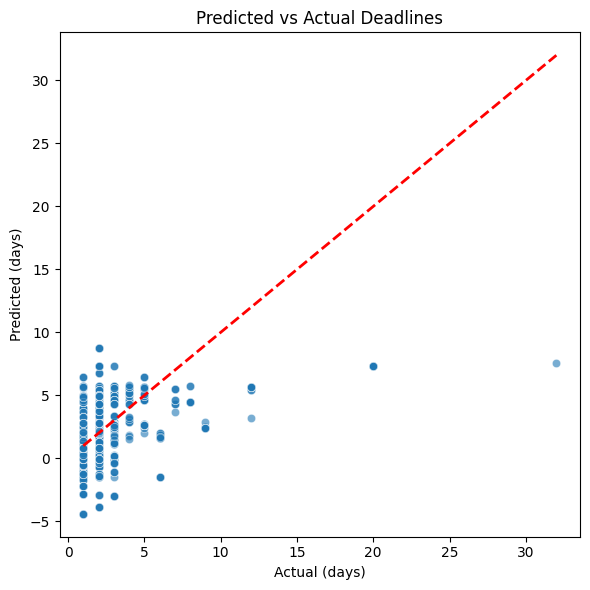

In [34]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=yte, y=y_pred, alpha=0.6)
plt.plot([yte.min(), yte.max()], [yte.min(), yte.max()], 'r--', lw=2)
plt.xlabel("Actual (days)")
plt.ylabel("Predicted (days)")
plt.title("Predicted vs Actual Deadlines")
plt.tight_layout()
plt.show()

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
bins = [0, 7, 14, 30, 60, 9999]   # categories: ≤7d, ≤14d, ≤30d, ≤60d, >60d
labels = ["≤7d", "≤14d", "≤30d", "≤60d", ">60d"]

y_true_cat = pd.cut(yte, bins=bins, labels=labels)
y_pred_cat = pd.cut(y_pred, bins=bins, labels=labels)

cm = confusion_matrix(y_true_cat, y_pred_cat, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Deadline Category Confusion Matrix")
plt.tight_layout()
plt.show()

TypeError: '<' not supported between instances of 'float' and 'str'

In [ ]:
# -----------------------------
# 7) INFERENCE & API
# -----------------------------
def heuristic_days(item,vel_default=1.0):
    sp=float(item.get("storyPoint",1)); pid=item.get("priorityId",3)
    infl=dependency_inflation(item); vel=item.get("velocity_sp_per_day",vel_default)
    base=max(1,math.ceil(sp/max(vel,1e-6)))
    return int(base*priority_multiplier(pid)*infl)

def predict_deadline(items):
    out=[]
    for it in items:
        row={**{k:0 for k in num_feats},**{k:"Unknown" for k in cat_feats}}
        row.update(it)
        df_one=pd.DataFrame([row])
        try:
            yhat=float(pipe_safe.predict(df_one[num_feats+cat_feats])[0])
            yhat=yhat*priority_multiplier(row.get("priorityid",3))*dependency_inflation(row)
            days=max(1,round(min(yhat,180)))
        except: days=heuristic_days(it)
        out.append({"predicted_deadline_days":int(days)})
    return out

In [ ]:
# -----------------------------
# 8) LOCAL DUMMY TESTS (no API)
# -----------------------------
if __name__ == "__main__":
    print("\n=== Running Dummy Deadline Predictions ===")

    dummy_items = [
        # 1️⃣ Example: normal story
        {
            "issuetype": "Story",
            "status": "To Do",
            "storyPoint": 5,
            "priorityid": 3,                # Major
            "blockedby": 0,
            "blocks": 0,
            "dependedon": 1,
            "dependedonby": 0,
            "issuelinks": 2,
            "subtasks": 1,
            "velocity_sp_per_day": 2.0,
            "noofdevelopers": 6,
            "sprintlength": 14,
            "completedissuesestimatesum": 40,
            "project": "Aurora"
        },
        # 2️⃣ Example: critical bug
        {
            "issuetype": "Bug",
            "status": "In Progress",
            "storyPoint": 2,
            "priorityid": 1,                # Blocker
            "blockedby": 1,
            "blocks": 0,
            "dependedon": 0,
            "dependedonby": 0,
            "velocity_sp_per_day": 3.0,
            "noofdevelopers": 4,
            "sprintlength": 10,
            "completedissuesestimatesum": 35,
            "project": "Meso"
        },
        # 3️⃣ Example: large feature
        {
            "issuetype": "Task",
            "status": "To Do",
            "storyPoint": 13,
            "priorityid": 4,                # Minor
            "blockedby": 2,
            "blocks": 1,
            "dependedon": 1,
            "dependedonby": 2,
            "issuelinks": 4,
            "subtasks": 3,
            "velocity_sp_per_day": 1.5,
            "noofdevelopers": 8,
            "sprintlength": 21,
            "completedissuesestimatesum": 60,
            "project": "SpringXD"
        },
        # 4️⃣ Example: small improvement
        {
            "issuetype": "Improvement",
            "status": "To Do",
            "storyPoint": 3,
            "priorityid": 2,                # Critical
            "blockedby": 0,
            "blocks": 0,
            "dependedon": 0,
            "dependedonby": 0,
            "velocity_sp_per_day": 2.5,
            "noofdevelopers": 5,
            "sprintlength": 14,
            "completedissuesestimatesum": 55,
            "project": "UserGrid"
        }
    ]

    preds = predict_deadline(dummy_items)
    for i, res in enumerate(preds, start=1):
        print(f"Test #{i}: {dummy_items[i-1]['project']} / {dummy_items[i-1]['issuetype']} "
              f"→ Predicted deadline: {res['predicted_deadline_days']} days")



=== Running Dummy Deadline Predictions ===
Test #1: Aurora / Story → Predicted deadline: 1 days
Test #2: Meso / Bug → Predicted deadline: 1 days
Test #3: SpringXD / Task → Predicted deadline: 3 days
Test #4: UserGrid / Improvement → Predicted deadline: 1 days


In [ ]:
dummy_pm_items = [
    {
        "issuetype": "Story",
        "priorityid": 3,
        "storyPoint": 5,
        "status": "To Do",
        "sprintlength": 14,
        "noofdevelopers": 6,
        "project": "Aurora"
    },
    {
        "issuetype": "Bug",
        "priorityid": 1,
        "storyPoint": 2,
        "status": "In Progress",
        "sprintlength": 10,
        "noofdevelopers": 4,
        "project": "Meso"
    },
    {
        "issuetype": "Task",
        "priorityid": 4,
        "storyPoint": 13,
        "status": "To Do",
        "sprintlength": 21,
        "noofdevelopers": 8,
        "project": "SpringXD"
    },
    {
        "issuetype": "Improvement",
        "priorityid": 2,
        "storyPoint": 3,
        "status": "To Do",
        "sprintlength": 14,
        "noofdevelopers": 5,
        "project": "UserGrid"
    },
    {
    "issuetype": "Story",
    "priorityid": 3,
    "storypoint": 5,
    "project": "Aurora"
    }

]

preds = predict_deadline(dummy_pm_items)
for i, res in enumerate(preds, start=1):
    print(f"{dummy_pm_items[i-1]['project']} / {dummy_pm_items[i-1]['issuetype']} "
          f"→ Predicted deadline: {res['predicted_deadline_days']} days")


Aurora / Story → Predicted deadline: 29 days
Meso / Bug → Predicted deadline: 35 days
SpringXD / Task → Predicted deadline: 35 days
UserGrid / Improvement → Predicted deadline: 25 days
Aurora / Story → Predicted deadline: 50 days
